usando uma imagem de tamanho menor:
 407 x 540

Dataset maior 30k 

In [ ]:
#
#  ambiente..
#
# ref https://colab.research.google.com/drive/151805XTDg--dgHb3-AXJCpnWaqRhop_2#scrollTo=qvyB0VG4j4zx

#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi
!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

#hard disk space that we can use
!df -h / | awk '{print $4}'


GPU 0: Tesla T4 (UUID: GPU-bb7d6997-b878-edee-fb6f-34ab3ae489af)
Sat Jan 16 14:06:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                       

In [ ]:
#
# mount and unzip
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# initialize...
#
checkdir_pre= None
checkdir    = "v140/try7-ds034/inicial"

NO_TEACH= True
FREEZE_ENCODER= False
TRAIN_LENGTH= 16
BATCH_SIZE = 32
EMBEDDING_DIM = 256
UNITS = 512
LEARNING_RATE=0.0005
# NUM_OF_WORDS= 220
SAMPLED= True
# VOCAB_SIZE= NUM_OF_WORDS+1 
SAVE_IF_BETTER_THAN_LOSS= 0.0   #dont save
_best_loss= 10  # best loss until now


In [ ]:
#
# Ref=> https://www.tensorflow.org/tutorials/text/image_captioning
# https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2
#
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle
from google.colab import drive
from pathlib import Path
import random
print(tf.__version__) 

Found GPU at: /device:GPU:0
2.4.0


In [ ]:
# !unzip -q '/content/drive/My Drive/mestrado/public/datasets/v6-labels-only.zip'

In [ ]:
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/dataset-v034--2lines-parts--42k.zip'

In [ ]:
# 
# unzipN

#
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/new-random-8lines--v1--test-only-2lines.zip'

In [ ]:
# !unzip -q '/content/drive/My Drive/mestrado/public/datasets/unified/unified-all-labels-noponct.zip'

In [ ]:
#
# basics
#
tstart= time.time()
def print_time():
  end = time.time()
  hours, rem = divmod(end-tstart, 3600)
  minutes, seconds = divmod(rem, 60)
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

print_time()

def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

00:00:00.00


In [ ]:
#
# tokenizer
#
def build_tokenizer():
  with open('/content/new-random-8lines--v1--test-only-2lines/all-labels-shuffle.pgn') as file:
    labels = [line.strip() for line in file]
  labels= ['<start> ' + label + ' <end>' for label in labels]

  # Choose the top 5000 words from the vocabulary
  print( 'building...')
  top_k = 5000   # para ajustar ao modelo antigo...
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                    lower=False,
                                                    oov_token="<unk>",
                                                    filters= ' ')
                                                    # filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

  #forca a usar sempre uma lista com todas as words com 1 ocorrecia de cada word
  tokenizer.fit_on_texts(labels)
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'
  return tokenizer

# NEW tokenizer
tokenizer= build_tokenizer()
print( 'total do vocabularario= ', len(tokenizer.word_index))    # expected 1578
# print( 'considerados no encoding= ', NUM_OF_WORDS)

VOCAB_SIZE= len(tokenizer.word_index)+1 
print( 'VOCAB_SIZE', VOCAB_SIZE)

building...
total do vocabularario=  179
VOCAB_SIZE 180


In [ ]:
#
# load images and labels
#
# def cleanup(line):
#     return re.sub('[^0-9a-zA-Z -]+', '', line).replace( 'x', '')

def load_data_from( path):
	image_files= glob( os.path.join( path, 'images/*.jpg'))
	image_files.sort()

	label_files= glob( os.path.join( path, 'labels/*.pgn'))
	label_files.sort()
	labels= [read_label( f) for f in label_files]
	# labels= [cleanup( x).lower() for x in labels]
	labels= ['<start> ' + label + ' <end>' for label in labels]

	# poderia ser menor... mas pega os primeiros 10. Nem precisava restringir...
	labels= [label.split()[0:16+1] for label in labels]

	# somente uma parte por enquanto
	if SAMPLED:
		n= int( len( image_files)*0.60)
		combined= list( zip( image_files, labels))
		random.Random(0).shuffle(combined)
		image_files[:], labels[:]= zip( *combined[:n])
		print( "SAMPLED!!  size= ", len( image_files), len( labels))

	label_indexes = tokenizer.texts_to_sequences(labels)
	for i in range( 0, 3):
		print( labels[i], '=>', label_indexes[i])
 
	return image_files, label_indexes, labels

#shuffle
# train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/shuffle_8lines_32K/train')
# valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/shuffle_8lines_32K/valid')

#final
train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/dataset-v034--2lines-parts--42k/train')
valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/dataset-v034--2lines-parts--42k/valid')

SAMPLED!!  size=  20164 20164
['<start>', 'e3', 'h6', 'Rb8', 'Bg7', '<end>'] => [2, 30, 51, 150, 171, 178]
['<start>', 'Bh4', 'dxc3', 'Qf6', 'c6', '<end>'] => [2, 52, 101, 100, 173, 178]
['<start>', 'Qd2', 'Ng5', 'c6', 'Nc3', '<end>'] => [2, 148, 119, 173, 13, 178]
SAMPLED!!  size=  5041 5041
['<start>', 'f6', 'Bd6', 'h4', 'Nxe4', '<end>'] => [2, 67, 50, 54, 85, 178]
['<start>', 'cxb3', 'Kd8', 'Bd7', 'Be7', '<end>'] => [2, 48, 83, 168, 78, 178]
['<start>', 'Qc3', 'gxf6', 'bxc6', 'Qxe4+', '<end>'] => [2, 153, 60, 58, 31, 178]


In [ ]:
#
# PREPROCESSAMENTO...
#

In [ ]:
#
# carrega VGG19
#
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape= (200, 862, 3))  # => gera (16, 19, 2048)
                                                # input_shape= (900, 678, 3))  # => gera (16, 19, 2048)
                                                # O input shape nao é obrigatorio, mas setando dá para
                                                # ver o tamanho do output
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
print( image_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 862, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 862, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 862, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 431, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 431, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 431, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 215, 128)      0     

In [ ]:
# -1 gera (None, 18, 21, 512)
ATTENTION_SHAPE= (12,53) #(28,21)
FEATURES_SHAPE = 512
ATTENTION_FEATURES_SHAPE = ATTENTION_SHAPE[0]*ATTENTION_SHAPE[1]  #16*19   # 308

In [ ]:
#
# build cache por preprocessed images
#
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (200, 862)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.image.resize(img, (540, 407)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path
	
def build_cache_for( img_name_vector):
  encode_train = sorted(set(img_name_vector))

  # Feel free to change batch_size according to your system configuration
  image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8) #(16)

  for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())
	  
	  
build_cache_for( train_img_names)
build_cache_for( valid_img_names)

In [ ]:
#
# build dataset
#

In [ ]:
# Load the numpy files
BUFFER_SIZE = 1000
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
  

def build_dataset( img_names, label_indexes):
  # deixa no mesmo tamanho, maximo 32
  label_indexes= [label[:32] for label in label_indexes]
  label_indexes= tf.keras.preprocessing.sequence.pad_sequences(label_indexes, padding='post')

  dataset = tf.data.Dataset.from_tensor_slices((img_names, label_indexes))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE, seed= 0).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

  
train_dataset= build_dataset( train_img_names, train_label_indexes)
valid_dataset= build_dataset( valid_img_names, valid_label_indexes)

train_num_steps= len( train_img_names)//BATCH_SIZE
valid_num_steps= len( valid_img_names)//BATCH_SIZE

In [ ]:
#
# Model
#

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # print( 'BahdanauAttention.features =>', features.shape) #(64, 64, 256), segundo 64=length(encoder_output)
    # print( 'BahdanauAttention.hidden =>', hidden.shape) #(64, 512)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # print( 'BahdanauAttention.hidden_with_time_axis =>', hidden_with_time_axis.shape) #(64, 1, 512)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
    # print( 'BahdanauAttention.score =>', score.shape)   #(64, 64, 512)

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # print( 'BahdanauAttention.attention_weights =>', attention_weights.shape)  #(64, 64, 1) segundo 64 vem do tamanho da sequencia apos cnn

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape)  #(64, 64, 256) segundo 64= length(encoder_output)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape) #(64, 256)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):

    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim, units):
        super(CNN_Encoder, self).__init__()
        self.units = units
        # shape after fc == (batch_size, 64, embedding_dim)
        # self.gru1= tf.keras.layers.GRU(self.units,
                                  #      dropout= ENCODER_DROPOUT,
                                  #  return_sequences=True) 
        self.bgru= tf.keras.layers.Bidirectional( tf.keras.layers.GRU(self.units,
                                       dropout= 0.2,
                                   return_sequences=True)) 
        self.drop= tf.keras.layers.Dropout( 0.2)
        # self.gru= tf.keras.layers.GRU(self.units,
        #                            return_sequences=True)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.bgru( x)
        # x = self.bgru2( x)
        x = self.drop(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU( self.units,
                                   dropout= 0.2,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # self.gru.trainable= False
    self.fc1 = tf.keras.layers.Dense(self.units)    #512
    # self.fc2 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001))    #256
    self.fcF = tf.keras.layers.Dense(vocab_size)    # 120

    # self.bn0 = tf.keras.layers.BatchNormalization()
    # self.bn1 = tf.keras.layers.BatchNormalization()
    # self.bn2 = tf.keras.layers.BatchNormalization()

    # self.drop0= tf.keras.layers.Dropout( 0.7)
    self.drop= tf.keras.layers.Dropout( 0.2)
    # self.drop2= tf.keras.layers.Dropout( 0.7)

    # self.dropout = tf.keras.layers.Dropout(0.5)
    # self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
    #                     center=True, scale=True, beta_initializer='zeros', 
    #                     gamma_initializer='ones', moving_mean_initializer='zeros', 
    #                     moving_variance_initializer='ones', beta_regularizer=None, 
    #                     gamma_regularizer=None, beta_constraint=None, 
    #                     gamma_constraint=None)

    self.attention = BahdanauAttention(self.units)
    if FREEZE_ENCODER:
      self.attention.trainable = False

  def freeze_attention(self):
      self.attention.trainable = False

  def call(self, x, features, hidden):
    # print( 'decoder.call=> ', x.shape, features.shape, hidden.shape) #(64, 1) (64, 64, 256) (64, 512)

    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    # print( 'decoder.attention=> ', context_vector.shape, attention_weights.shape) #(64, 256) (64, 64, 1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # print( 'decoder.embedding=> ', x.shape) #(64, 1, 256)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # print( 'decoder.concat=> ', x.shape) #(64, 1, 512)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output = self.bn0(output)
    # output = self.drop0(output)

    x = self.fc1(output)    #fc1= Dense( 512)
    # x= output
    # x = self.bn1(x)
    x = self.drop(x)

    x = tf.reshape(x, (-1, x.shape[2])) 
    # x = self.fc2(x) # 256
    # x = self.bn2(x)
    # x = self.drop2(x)

    # x= self.dropout(x)
    # x= self.batchnormalization(x)
    x = self.fcF(x) #fc2= Dense(5000)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# 
# build the model
#

In [ ]:
encoder = CNN_Encoder(EMBEDDING_DIM, UNITS)
if FREEZE_ENCODER:
  encoder.trainable = False

decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # print( 'loss_function.real, pred', real.shape, pred.shape)  #(64,) (64, 5001)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
#
# checkpoint manager
#

In [ ]:
def build_and_recover_checkpoint( checkdir_pre, checkdir):
  ckpt = tf.train.Checkpoint(encoder=encoder,
                              decoder=decoder,
                              optimizer = optimizer)
                              
  checkpoint_path = "/content/drive/My Drive/mestrado/"+checkdir+"/checkpoints/train"
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

  epoch = 0
  if ckpt_manager.latest_checkpoint:
    print( "restoring from current "+ ckpt_manager.latest_checkpoint)
    epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print( '_epoch= ', epoch)
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
  elif not checkdir_pre is None:
    checkpoint_pre_path = "/content/drive/My Drive/mestrado/"+checkdir_pre+"/checkpoints/train"
    lastest_pre= tf.train.latest_checkpoint(checkpoint_pre_path)
    if lastest_pre:
      print( "restore from pretraining  "+ lastest_pre, '...')
      ckpt.restore( tf.train.latest_checkpoint(checkpoint_pre_path))
  else:
      pass
  return ckpt_manager, ckpt, epoch

def restore_checkpoint_to_last():
  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print( 'restored!', ckpt_manager.latest_checkpoint)
  else:
    print( 'no checkpoint found!!')

ckpt_manager, ckpt, _epoch= build_and_recover_checkpoint( checkdir_pre, checkdir)

In [ ]:
#
# training
#

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

def reset_metric_plot():
  global loss_plot_train, loss_plot_valid, acc_plot_train, acc_plot_valid
  loss_plot_train = []
  loss_plot_valid = []
  acc_plot_train = []
  acc_plot_valid = []
reset_metric_plot()

def plot_metrics():
  plt.plot(loss_plot_train)
  plt.plot(loss_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  plt.gca().legend(('train loss','validation loss'))
  plt.show()

  plt.plot(acc_plot_train)
  plt.plot(acc_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.title('Acc Plot')
  plt.gca().legend(('train acc','validation acc'))
  plt.show()  

In [ ]:
@tf.function
def train_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, train_length+1): 
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      # tf.keras.backend.print_tensor( predictions)
      # tf.keras.backend.print_tensor( tf.reduce_max( predictions))
      # tf.keras.backend.print_tensor( tf.reduce_min( predictions))

      loss += loss_function(target[:, i], predictions)
      train_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))

  # update model
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
def call_train_step_for_debug():
  batch, (img_tensor, target)= next( enumerate(train_dataset))
  batch_loss, t_loss = train_step(img_tensor[0:1], target[0:1], 4)
  print( 'loss= ', batch_loss.numpy())

# call_train_step_for_debug()

In [ ]:
#
# call train without update the gradient
#
@tf.function
def test_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)
  features = encoder(img_tensor)

  for i in range(1, train_length+1):
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)
      valid_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))
  return loss, total_loss


In [ ]:
def train_more( loss_target, train_length, val_loss_limit): #, n_epoch):
  global _epoch
  global _best_loss

  MAX_EPOCH=200 

  print( "-- loss_target=>", loss_target, " train_length=", train_length)
  for _ in range(0,MAX_EPOCH):
      _epoch+= 1
      start = time.time()
      total_loss = 0
      
      train_acc_metric.reset_states()
      valid_acc_metric.reset_states()

      #
      # training loop
      #
      for (batch, (img_tensor, target)) in enumerate(train_dataset):
          batch_loss, t_loss = train_step(img_tensor, target, train_length)
          total_loss += t_loss

          if batch % 50 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(
                _epoch, batch, batch_loss.numpy() / train_length))

      train_loss= total_loss/train_num_steps
      loss_plot_train.append(train_loss)
      train_acc = float(train_acc_metric.result())
      acc_plot_train.append(train_acc)

      #
      # validation loop
      #
      valid_total_loss = 0
      for (batch, (img_tensor, target)) in enumerate(valid_dataset):
          batch_loss, t_loss = test_step(img_tensor, target, train_length)
          valid_total_loss += t_loss
      valid_loss= valid_total_loss / valid_num_steps
      loss_plot_valid.append(valid_loss)
      valid_acc = float(valid_acc_metric.result())
      acc_plot_valid.append(valid_acc)

      #
      # print..
      #

      print ('Epoch {} Loss {:.6f}  acc: {:.4f} [ Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                                  _epoch,
                                  train_loss, 
                                  train_acc,
                                  valid_loss, 
                                  valid_acc))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
      print_time()    


      # 
      # target reached?
      #
      if loss_target> 0 and (train_loss)<= loss_target:
        print( "Target reached! stop!", ' len= ', train_length)

        ckpt_manager.save()  
        print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)
        plot_metrics()
        return True

      if train_loss< _best_loss:
        _best_loss= train_loss
        print( 'New record! _best_loss= ', _best_loss)
        if train_loss< SAVE_IF_BETTER_THAN_LOSS :
            ckpt_manager.save()  
            print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)

      # se validacao estoura significa que esta desaprendendo attention, portanto faz abort
      # TODO: Como implementar early stop?
      if valid_loss>= val_loss_limit:   
        print( "Oops, desaprendendo. Aborta sem salvar!")
        return False

  print( 'epoch exceeded')
  return False
    

In [ ]:
MAX_RETRY= 0
def train_more_with_retry( loss_target, _length, valid_loss_limit):
  retry_count= 0
  while True:
    print( 'len=', _length, ' try_count=', retry_count)
    ok= train_more( loss_target, _length, valid_loss_limit)
    if ok: 
      return True

    if retry_count>= MAX_RETRY:
      print( 'givup!')
      return False
    retry_count+= 1

    #volta para inicio da iteracao anterior
    restore_checkpoint_to_last()
  return False


In [ ]:
def evaluate(image, _length, no_teach= True):
    # print( 'evaluate>>')
    # print( "_length", _length)

    attention_plot = np.zeros((32, ATTENTION_FEATURES_SHAPE))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([0 if no_teach else tokenizer.word_index['<start>']], 0)
    result = []
    # result_top5 = []

    for i in range(_length): 
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id] if predicted_id< len( tokenizer.index_word) else "OUT")

        # predicted_id_top5= tf.math.top_k( predictions, 10)[1][0].numpy()
        # result_top5.append( [tokenizer.index_word[id] for id in predicted_id_top5])
        dec_input = tf.expand_dims([0 if no_teach else predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, None

In [ ]:
def plot_attention(image, result, attention_plot, expected= None):
  print( image)
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(50, 50))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], ATTENTION_SHAPE) 
    ax = fig.add_subplot(8, 9, l+1)
    if expected is None or l>= len( expected):
      ax.set_title(result[l], fontsize= 40)
    else:
      ax.set_title(result[l]+" ("+expected[l]+")", fontsize= 40)
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()


In [ ]:
def evaluate_random_from_dataset( image_path, label_words, train_length):
  result, attention_plot, _ = evaluate(image_path, train_length)

  # TODO: Pode estar errado...
  m = tf.keras.metrics.Accuracy()
  m.update_state( 
          tokenizer.texts_to_sequences(label_words)[1:train_length+1],
          tokenizer.texts_to_sequences(result)[0:train_length])
          # [tokenizer.word_index[w] for w in label_words][1:train_length+1], 
          # [tokenizer.word_index[w] for w in result][0:train_length])

  # print( 'accurary', float( m.result()))
  print ('expected=', label_words[1:])
  print ('predicted=', result)
  plot_attention(image_path, result, attention_plot, label_words[1:])

def evaluate_train( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( train_img_names[i], train_label_words[i], train_length) 

def evaluate_valid( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( valid_img_names[i], valid_label_words[i], train_length) 

#evaluate_train(1, 32)

In [ ]:
def evaluate_full_valid_dataset(_length):
    total_loss = 0
    valid_acc_metric.reset_states()
    for (batch, (img_tensor, target)) in enumerate(valid_dataset):
        batch_loss, t_loss = test_step(img_tensor, target, _length)
        total_loss += t_loss

    valid_loss= total_loss / valid_num_steps
    valid_acc = float(valid_acc_metric.result())
    print ('len {} Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                        _length,
                        valid_loss, 
                        valid_acc))


In [ ]:
#
# Adicionais para teste da acuracia do test set
#

In [ ]:
import nltk
from nltk.metrics import distance

def cir_word( hp, gt):
    return distance.edit_distance(hp, gt)/len( gt)
	
def cir_line( expected, predicted):
    return tf.reduce_mean( [cir_word(e, p) for (e, p) in zip( expected, predicted)]).numpy()

def cir_set( labels, result, _len= None):
    if _len is None:
      _len= len( labels)
    return tf.reduce_mean( [cir_line(e[:_len], p[:_len]) for (e, p) in zip( labels, result)]).numpy()


In [ ]:
def load_from_path( path, max= None):
  test_images= glob( os.path.join( path, 'images/*.jpg'))
  test_images.sort()

  test_labels_files= glob( os.path.join( path, 'labels/*.pgn'))
  test_labels_files.sort()
  test_labels= [read_label( f) for f in test_labels_files]
  # test_labels= [cleanup( x).lower() for x in test_labels]
  test_labels= [label.split() for label in test_labels]
  if max is None:
    return test_images, test_labels
  else:
    return test_images[:max], test_labels[:max]

def load_test():
  return load_from_path( '/content/new-random-8lines--v1--test-only-2lines/test') 

def load_test_2():
  return load_from_path( '/content/new-random-8lines--v1--test-only-2lines/test--v2') 
  
def evaluate_all_data(images,labels,maxlen,no_teach=True):
  result_ac= []
  print( 'EVALUATING ALL DATA',len( images))
  # treina todos
  result= []
  # best= { "score": None }
  # worst= { "score": None }
  for i in range(0,len( images)):
    if( i%100== 0):
      print( 'evaluating ', i, '...')
    r, attention_plot, _ = evaluate(images[i], maxlen, no_teach)
    result.append( r)

    # habilitar para exibir resultado e esperado
    if i< 5:
      print( '------------------------', i, '------------------------------')
      print( 'predicted', r)
      print( 'expected', labels[i])

      #habilitar para plotar attention
      plot_attention(images[i], r, attention_plot, labels[i])

  # calcula a acuracia para cada tamanho
  for _len in range(1,maxlen+1):
    m = tf.keras.metrics.Accuracy()

    # acuracia para cada teste, até o tamanho atual
    for i in range( 0, len( result)):
      uselen= min( len( labels[i]), len( result[i]), _len)
      m.update_state( 
              tokenizer.texts_to_sequences(labels[i])[:uselen],
              tokenizer.texts_to_sequences(result[i])[:uselen])
              # [tokenizer.word_index[w] if w in tokenizer.word_index else 0 for w in labels[i]][:uselen], 
              # [tokenizer.word_index[w] if w in tokenizer.word_index else 0  for w in result[i]][:uselen])
    
    print( 'len', _len, 'accuracy', float( m.result()), 'cir', cir_set( labels, result, _len))
    result_ac.append( float( m.result()))

  return result_ac

def plot_accuracy( checkpoint, result_acc):
  plt.xlabel('sequence length')
  plt.ylabel('accuracy')
  for r, check_name in result_acc:
    plt.plot(r)
  plt.title('checkpoint: '+ checkpoint)
  plt.gca().legend([check_name for _, check_name in result_acc])
  plt.show()
  
def make_evaluations_test_set(_len):
  # for check_dir, no_teach in checkpoints:
    # print( 'checkpoint', check_dir)
    # restore_from( check_dir)
  result_acc= []
  result_acc.append( (evaluate_all_data(*load_test(), _len), 'test'))
  # result_acc.append( (evaluate_all_data(*load_test_2(), _len), 'test--v2'))
  plot_accuracy( checkdir, result_acc)

# make_evaluations_test_set(1)

In [ ]:
#
# training loop, attention
#

iniciando para lengh 1  target 0.25
len= 1  try_count= 0
-- loss_target=> 0.25  train_length= 1
Epoch 1 Batch 0 Loss 5.1674
Epoch 1 Batch 50 Loss 4.8142
Epoch 1 Batch 100 Loss 4.7130
Epoch 1 Batch 150 Loss 4.4498
Epoch 1 Batch 200 Loss 4.7347
Epoch 1 Batch 250 Loss 4.5989
Epoch 1 Batch 300 Loss 4.6423
Epoch 1 Batch 350 Loss 3.8876
Epoch 1 Batch 400 Loss 3.7426
Epoch 1 Batch 450 Loss 2.7709
Epoch 1 Batch 500 Loss 2.5324
Epoch 1 Batch 550 Loss 2.1082
Epoch 1 Batch 600 Loss 2.7693
Epoch 1 Loss 3.905039  acc: 0.1205 [ Validation Loss 2.397141 valid_acc: 0.3249 ]
Time taken for 1 epoch 1132.914335489273 sec

00:32:35.62
New record! _best_loss=  tf.Tensor(3.905039, shape=(), dtype=float32)
Epoch 2 Batch 0 Loss 2.3540
Epoch 2 Batch 50 Loss 2.5030
Epoch 2 Batch 100 Loss 2.2611
Epoch 2 Batch 150 Loss 1.7706
Epoch 2 Batch 200 Loss 2.3998
Epoch 2 Batch 250 Loss 2.0001
Epoch 2 Batch 300 Loss 1.8625
Epoch 2 Batch 350 Loss 1.3643
Epoch 2 Batch 400 Loss 1.1075
Epoch 2 Batch 450 Loss 1.4588
Epoch 2 Ba

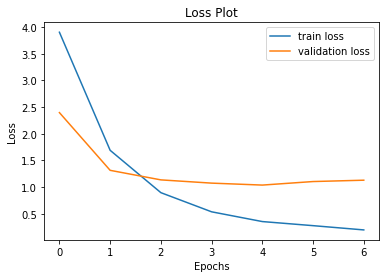

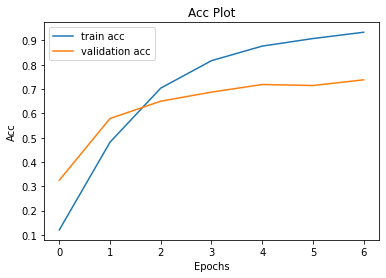

02:25:04.44
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


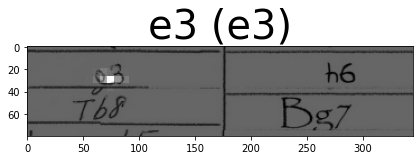

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


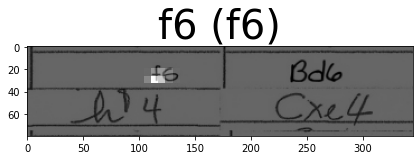

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


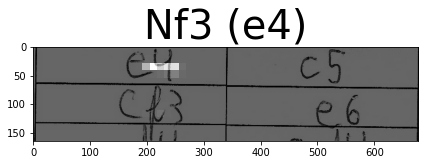

------------------------ 1 ------------------------------
predicted ['Nd5']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


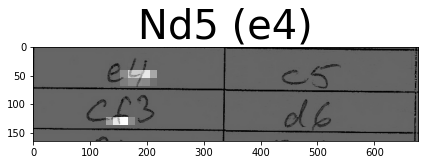

------------------------ 2 ------------------------------
predicted ['Nfd7']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


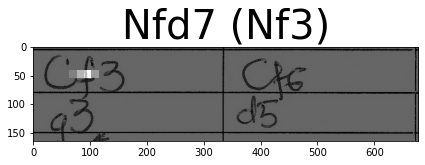

------------------------ 3 ------------------------------
predicted ['d4']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


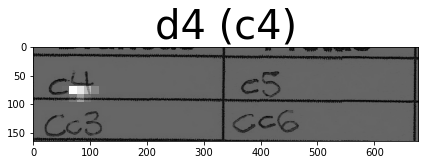

------------------------ 4 ------------------------------
predicted ['d4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


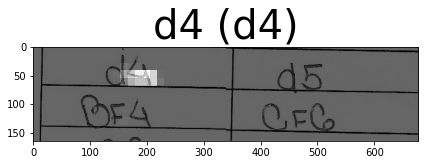

evaluating  100 ...
len 1 accuracy 0.4736842215061188 cir 0.35745615


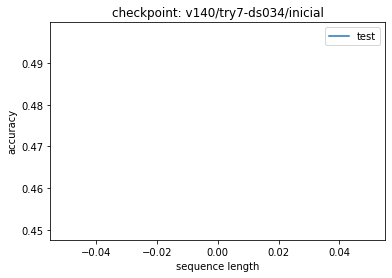

iniciando para lengh 1  target 0.1
len= 1  try_count= 0
-- loss_target=> 0.1  train_length= 1
Epoch 8 Batch 0 Loss 0.3802
Epoch 8 Batch 50 Loss 0.1946
Epoch 8 Batch 100 Loss 0.3551
Epoch 8 Batch 150 Loss 0.1405
Epoch 8 Batch 200 Loss 0.2727
Epoch 8 Batch 250 Loss 0.1875
Epoch 8 Batch 300 Loss 0.1596
Epoch 8 Batch 350 Loss 0.1210
Epoch 8 Batch 400 Loss 0.2459
Epoch 8 Batch 450 Loss 0.0753
Epoch 8 Batch 500 Loss 0.0573
Epoch 8 Batch 550 Loss 0.4415
Epoch 8 Batch 600 Loss 0.1307
Epoch 8 Loss 0.187753  acc: 0.9353 [ Validation Loss 1.161490 valid_acc: 0.7296 ]
Time taken for 1 epoch 1125.550095319748 sec

02:46:57.41
New record! _best_loss=  tf.Tensor(0.18775325, shape=(), dtype=float32)
Epoch 9 Batch 0 Loss 0.1275
Epoch 9 Batch 50 Loss 0.0560
Epoch 9 Batch 100 Loss 0.1475
Epoch 9 Batch 150 Loss 0.0835
Epoch 9 Batch 200 Loss 0.1924
Epoch 9 Batch 250 Loss 0.0903
Epoch 9 Batch 300 Loss 0.1347
Epoch 9 Batch 350 Loss 0.0467
Epoch 9 Batch 400 Loss 0.0734
Epoch 9 Batch 450 Loss 0.0280
Epoch 9 Ba

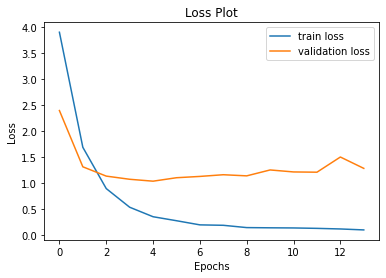

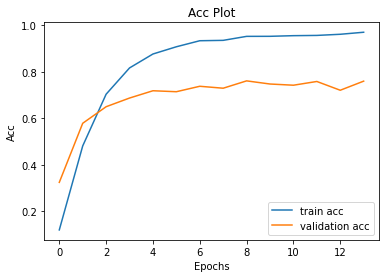

04:40:08.66
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


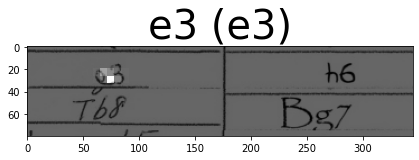

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


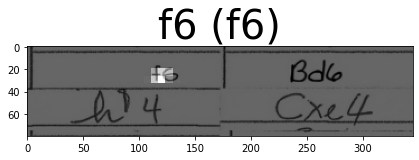

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


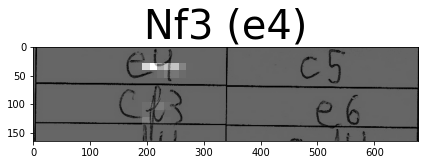

------------------------ 1 ------------------------------
predicted ['d4']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


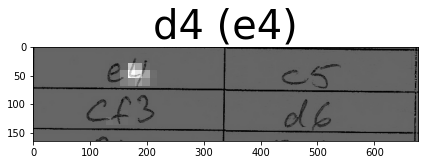

------------------------ 2 ------------------------------
predicted ['Nf3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


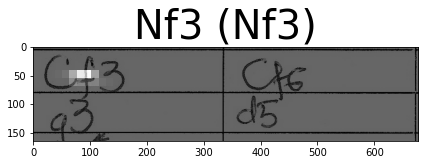

------------------------ 3 ------------------------------
predicted ['Nf3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


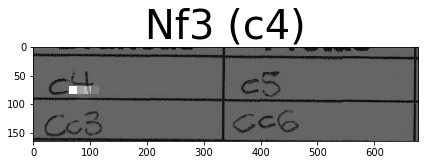

------------------------ 4 ------------------------------
predicted ['d4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


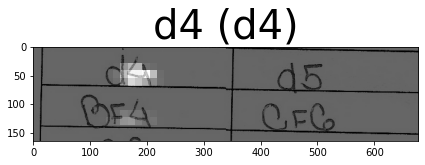

evaluating  100 ...
len 1 accuracy 0.6140350699424744 cir 0.2653509


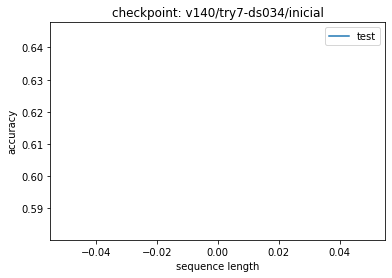

iniciando para lengh 2  target 0.25
len= 2  try_count= 0
-- loss_target=> 0.25  train_length= 2
Epoch 15 Batch 0 Loss 13.8031
Epoch 15 Batch 50 Loss 3.3859
Epoch 15 Batch 100 Loss 0.5966
Epoch 15 Batch 150 Loss 0.6460
Epoch 15 Batch 200 Loss 0.6076
Epoch 15 Batch 250 Loss 0.3324
Epoch 15 Batch 300 Loss 0.4337
Epoch 15 Batch 350 Loss 0.4168
Epoch 15 Batch 400 Loss 0.5855
Epoch 15 Batch 450 Loss 0.4980
Epoch 15 Batch 500 Loss 0.3396
Epoch 15 Batch 550 Loss 0.4675
Epoch 15 Batch 600 Loss 0.4602
Epoch 15 Loss 0.914293  acc: 0.7865 [ Validation Loss 0.636930 valid_acc: 0.8144 ]
Time taken for 1 epoch 1141.4375441074371 sec

05:02:22.64
Epoch 16 Batch 0 Loss 0.2271
Epoch 16 Batch 50 Loss 0.5859
Epoch 16 Batch 100 Loss 0.1596
Epoch 16 Batch 150 Loss 0.2423
Epoch 16 Batch 200 Loss 0.1254
Epoch 16 Batch 250 Loss 0.1537
Epoch 16 Batch 300 Loss 0.1043
Epoch 16 Batch 350 Loss 0.1689
Epoch 16 Batch 400 Loss 0.1674
Epoch 16 Batch 450 Loss 0.0789
Epoch 16 Batch 500 Loss 0.1321
Epoch 16 Batch 550 Loss

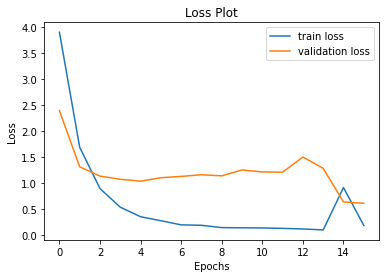

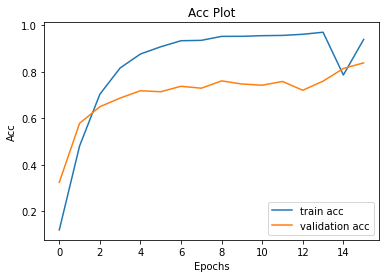

05:21:20.93
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3', 'h6']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


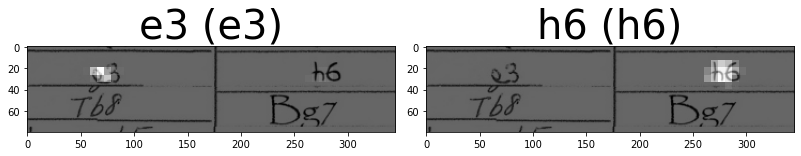

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6', 'Bd6']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


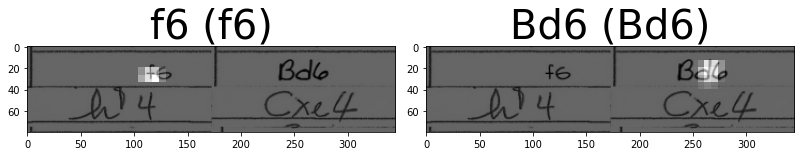

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['c4', 'c5']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


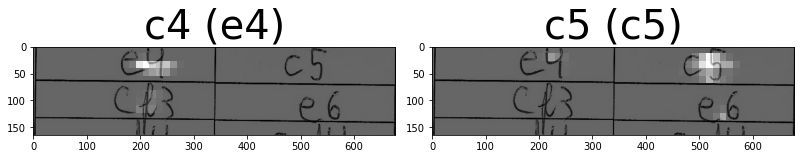

------------------------ 1 ------------------------------
predicted ['c4', 'c6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


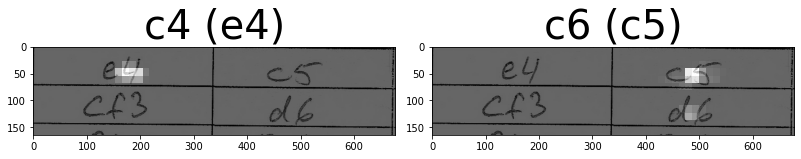

------------------------ 2 ------------------------------
predicted ['Nd5', 'Nf6']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


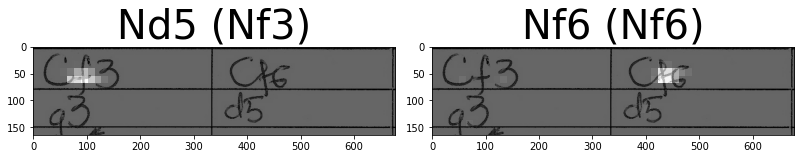

------------------------ 3 ------------------------------
predicted ['c4', 'e5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


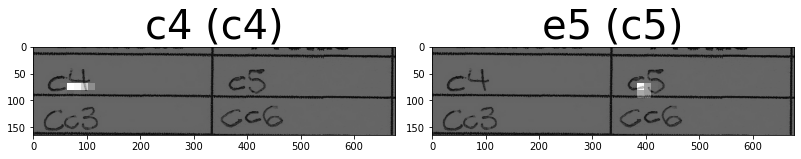

------------------------ 4 ------------------------------
predicted ['d4', 'd5']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


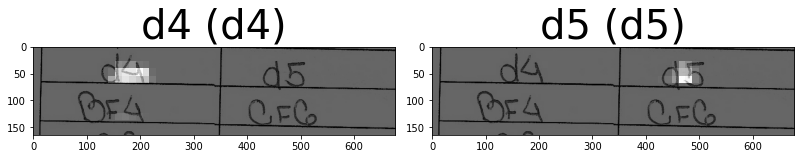

evaluating  100 ...
len 1 accuracy 0.5701754093170166 cir 0.27558482
len 2 accuracy 0.6052631735801697 cir 0.25438598


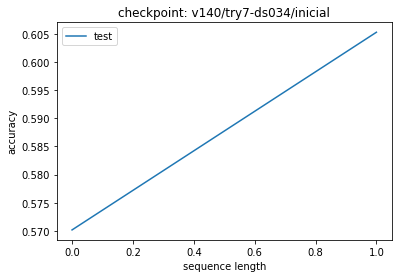

iniciando para lengh 2  target 0.1
len= 2  try_count= 0
-- loss_target=> 0.1  train_length= 2
Epoch 17 Batch 0 Loss 0.1387
Epoch 17 Batch 50 Loss 0.1640
Epoch 17 Batch 100 Loss 0.1016
Epoch 17 Batch 150 Loss 0.1150
Epoch 17 Batch 200 Loss 0.0606
Epoch 17 Batch 250 Loss 0.0212
Epoch 17 Batch 300 Loss 0.1706
Epoch 17 Batch 350 Loss 0.0617
Epoch 17 Batch 400 Loss 0.1024
Epoch 17 Batch 450 Loss 0.0420
Epoch 17 Batch 500 Loss 0.2320
Epoch 17 Batch 550 Loss 0.0223
Epoch 17 Batch 600 Loss 0.1445
Epoch 17 Loss 0.110241  acc: 0.9650 [ Validation Loss 0.729947 valid_acc: 0.8267 ]
Time taken for 1 epoch 1135.7588651180267 sec

05:43:29.55
New record! _best_loss=  tf.Tensor(0.11024066, shape=(), dtype=float32)
Epoch 18 Batch 0 Loss 0.1822
Epoch 18 Batch 50 Loss 0.0393
Epoch 18 Batch 100 Loss 0.0442
Epoch 18 Batch 150 Loss 0.0589
Epoch 18 Batch 200 Loss 0.0361
Epoch 18 Batch 250 Loss 0.0685
Epoch 18 Batch 300 Loss 0.0828
Epoch 18 Batch 350 Loss 0.0323
Epoch 18 Batch 400 Loss 0.0851
Epoch 18 Batch 4

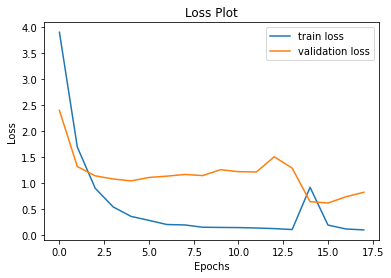

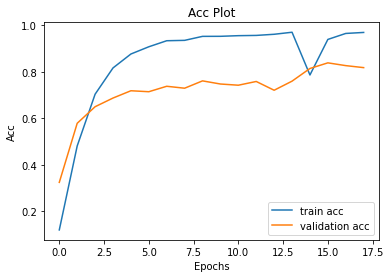

06:02:32.57
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3', 'h6']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


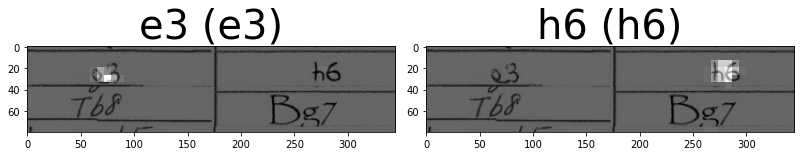

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6', 'Bd6']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


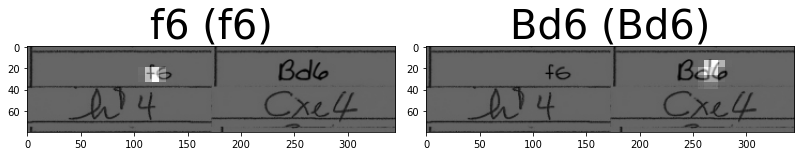

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


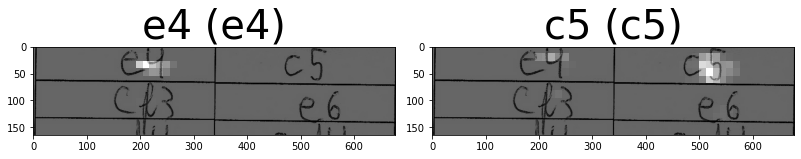

------------------------ 1 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


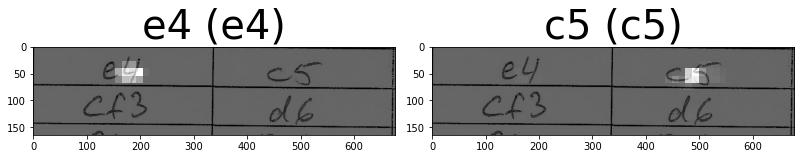

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


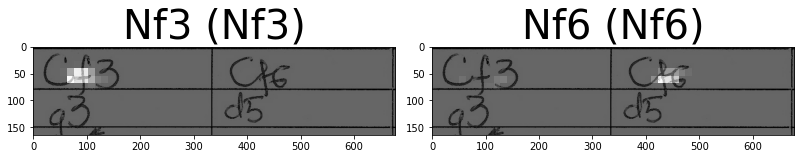

------------------------ 3 ------------------------------
predicted ['Nf3', 'e5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


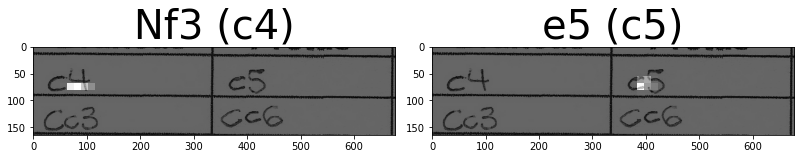

------------------------ 4 ------------------------------
predicted ['d4', 'd5']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


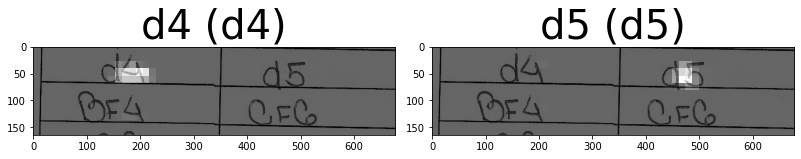

evaluating  100 ...
len 1 accuracy 0.6491228342056274 cir 0.23684211
len 2 accuracy 0.6447368264198303 cir 0.25146198


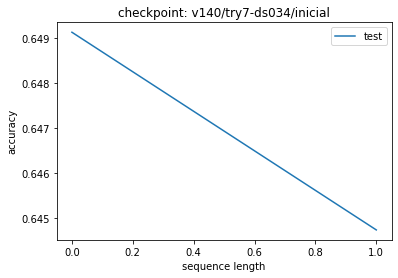

iniciando para lengh 3  target 0.25
len= 3  try_count= 0
-- loss_target=> 0.25  train_length= 3
Epoch 19 Batch 0 Loss 8.1622
Epoch 19 Batch 50 Loss 2.0188
Epoch 19 Batch 100 Loss 0.6357
Epoch 19 Batch 150 Loss 0.4825
Epoch 19 Batch 200 Loss 0.2762
Epoch 19 Batch 250 Loss 0.1870
Epoch 19 Batch 300 Loss 0.2955
Epoch 19 Batch 350 Loss 0.3763
Epoch 19 Batch 400 Loss 0.3542
Epoch 19 Batch 450 Loss 0.4630
Epoch 19 Batch 500 Loss 0.3809
Epoch 19 Batch 550 Loss 0.3425
Epoch 19 Batch 600 Loss 0.2651
Epoch 19 Loss 0.642999  acc: 0.8506 [ Validation Loss 0.629444 valid_acc: 0.8249 ]
Time taken for 1 epoch 1148.2584764957428 sec

06:24:55.71
Epoch 20 Batch 0 Loss 0.2531
Epoch 20 Batch 50 Loss 0.1495
Epoch 20 Batch 100 Loss 0.2738
Epoch 20 Batch 150 Loss 0.2120
Epoch 20 Batch 200 Loss 0.0876
Epoch 20 Batch 250 Loss 0.1437
Epoch 20 Batch 300 Loss 0.0453
Epoch 20 Batch 350 Loss 0.0939
Epoch 20 Batch 400 Loss 0.0738
Epoch 20 Batch 450 Loss 0.0617
Epoch 20 Batch 500 Loss 0.1257
Epoch 20 Batch 550 Loss 

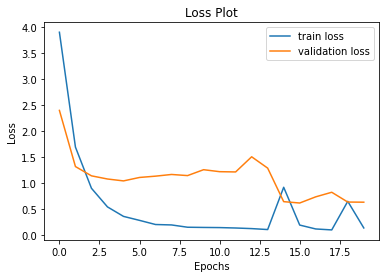

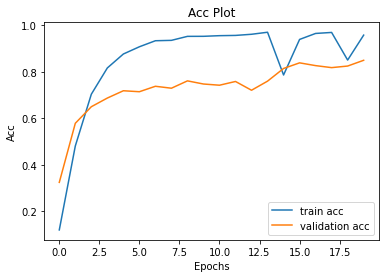

06:43:55.32
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3', 'h6', 'Rb8']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


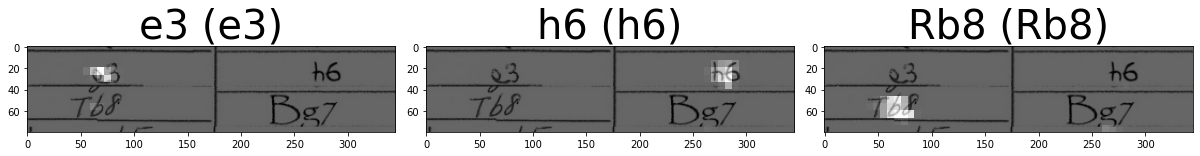

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6', 'Bd6', 'h4']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


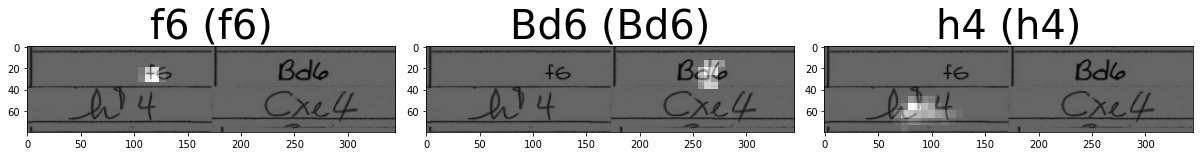

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['c4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


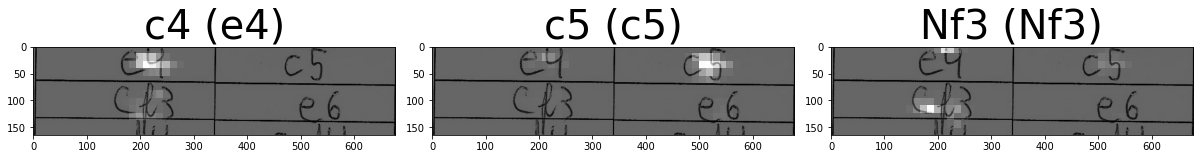

------------------------ 1 ------------------------------
predicted ['c4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


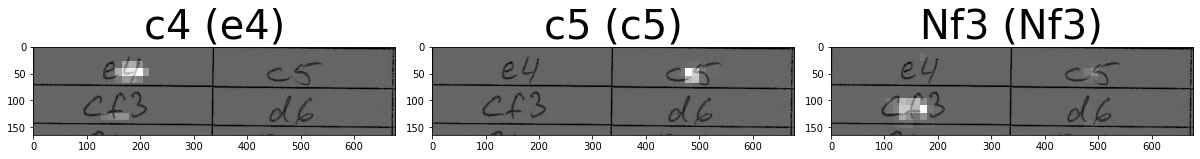

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf3', 'g3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


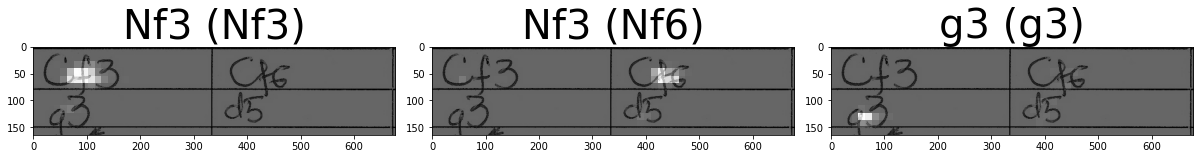

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'c5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


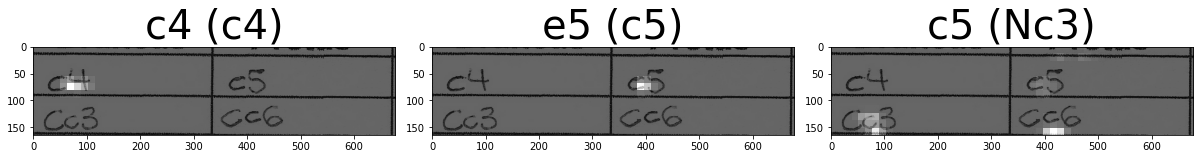

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


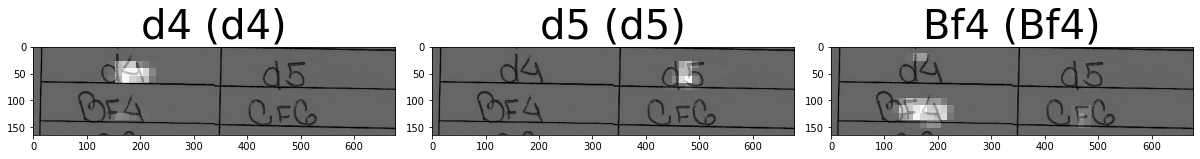

evaluating  100 ...
len 1 accuracy 0.5438596606254578 cir 0.27558482
len 2 accuracy 0.6052631735801697 cir 0.24232458
len 3 accuracy 0.6228070259094238 cir 0.2541423


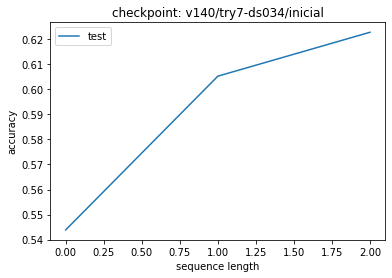

iniciando para lengh 3  target 0.1
len= 3  try_count= 0
-- loss_target=> 0.1  train_length= 3
Epoch 21 Batch 0 Loss 0.0793
Epoch 21 Batch 50 Loss 0.0823
Epoch 21 Batch 100 Loss 0.0546
Epoch 21 Batch 150 Loss 0.0479
Epoch 21 Batch 200 Loss 0.0538
Epoch 21 Batch 250 Loss 0.0159
Epoch 21 Batch 300 Loss 0.0784
Epoch 21 Batch 350 Loss 0.1070
Epoch 21 Batch 400 Loss 0.0951
Epoch 21 Batch 450 Loss 0.0475
Epoch 21 Batch 500 Loss 0.0425
Epoch 21 Batch 550 Loss 0.0553
Epoch 21 Batch 600 Loss 0.0292
Epoch 21 Loss 0.077998  acc: 0.9740 [ Validation Loss 0.608911 valid_acc: 0.8603 ]
Time taken for 1 epoch 1139.4725151062012 sec

07:06:11.92
Target reached! stop!  len=  3
saved checkpoint! /content/drive/My Drive/mestrado/v140/try7-ds034/inicial/checkpoints/train/ckpt-6


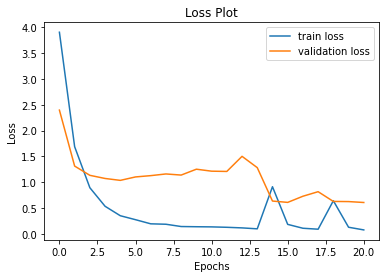

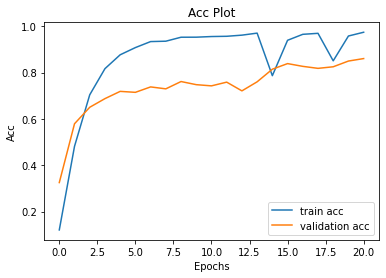

07:06:12.64
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3', 'h6', 'Rb8']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


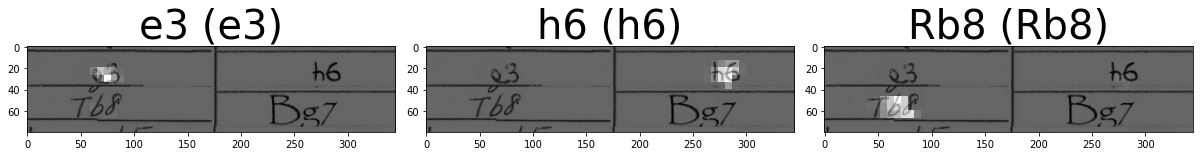

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6', 'Bd6', 'h4']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


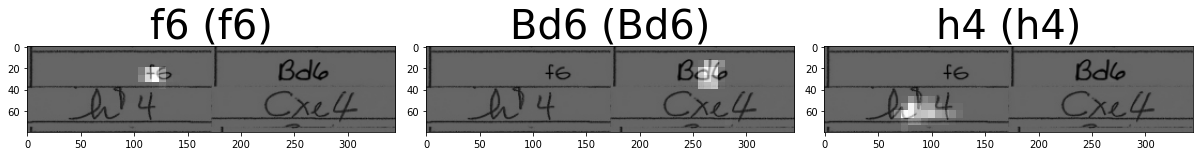

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['c4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


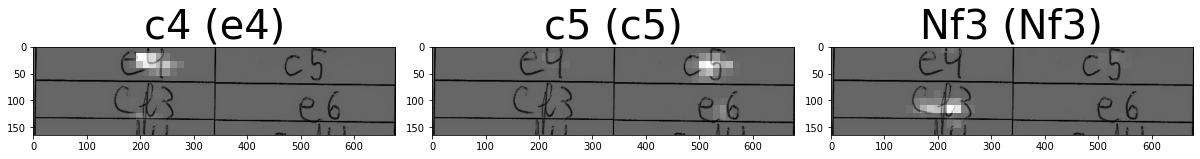

------------------------ 1 ------------------------------
predicted ['Nf1', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


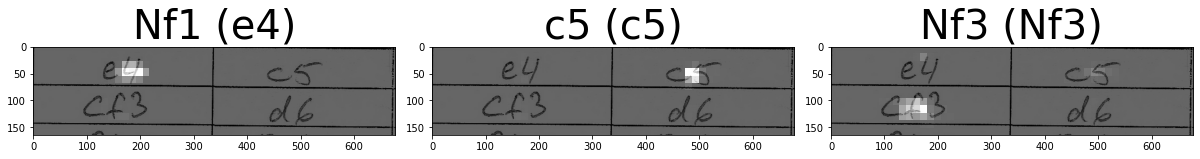

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


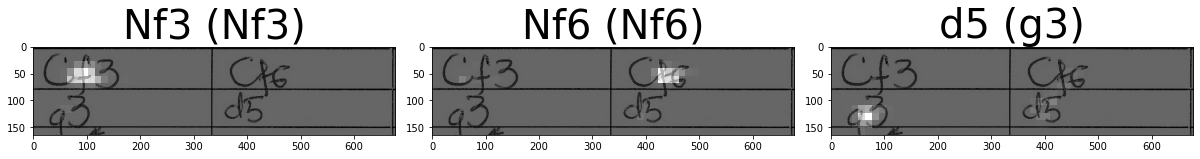

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


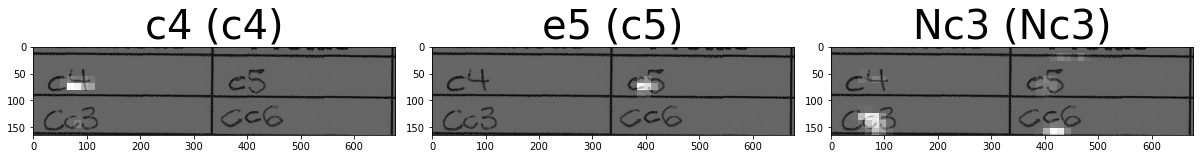

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


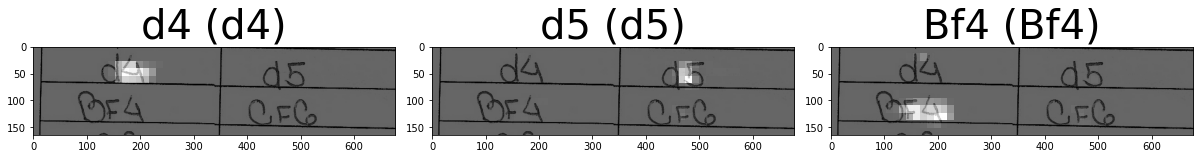

evaluating  100 ...
len 1 accuracy 0.6052631735801697 cir 0.23903508
len 2 accuracy 0.6184210777282715 cir 0.2496345
len 3 accuracy 0.6491228342056274 cir 0.25121832


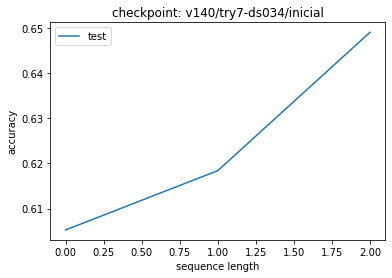

iniciando para lengh 4  target 0.25
len= 4  try_count= 0
-- loss_target=> 0.25  train_length= 4
Epoch 22 Batch 0 Loss 5.8069
Epoch 22 Batch 50 Loss 0.2763
Epoch 22 Batch 100 Loss 0.1614
Epoch 22 Batch 150 Loss 0.3088
Epoch 22 Batch 200 Loss 0.1815
Epoch 22 Batch 250 Loss 0.1522
Epoch 22 Batch 300 Loss 0.1499
Epoch 22 Batch 350 Loss 0.1863
Epoch 22 Batch 400 Loss 0.2577
Epoch 22 Batch 450 Loss 0.1762
Epoch 22 Batch 500 Loss 0.1543
Epoch 22 Batch 550 Loss 0.2412
Epoch 22 Batch 600 Loss 0.1851
Epoch 22 Loss 0.298630  acc: 0.9208 [ Validation Loss 0.498038 valid_acc: 0.8688 ]
Time taken for 1 epoch 1151.711606502533 sec

07:28:41.76
Epoch 23 Batch 0 Loss 0.1456
Epoch 23 Batch 50 Loss 0.0710
Epoch 23 Batch 100 Loss 0.1758
Epoch 23 Batch 150 Loss 0.0992
Epoch 23 Batch 200 Loss 0.0597
Epoch 23 Batch 250 Loss 0.0488
Epoch 23 Batch 300 Loss 0.0608
Epoch 23 Batch 350 Loss 0.1898
Epoch 23 Batch 400 Loss 0.0666
Epoch 23 Batch 450 Loss 0.0749
Epoch 23 Batch 500 Loss 0.0842
Epoch 23 Batch 550 Loss 0

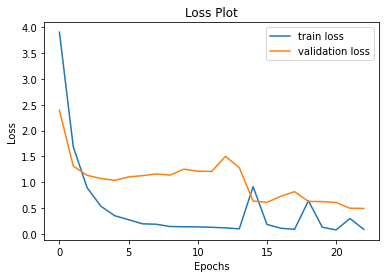

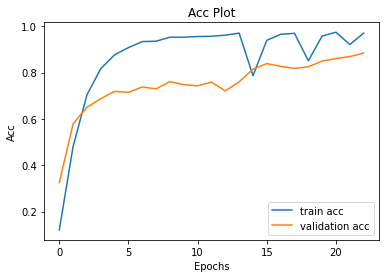

07:47:41.89
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3', 'h6', 'Rb8', 'Bg7']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


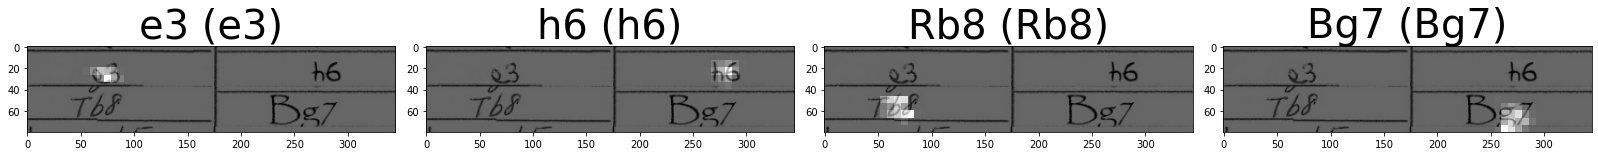

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6', 'Bd6', 'h4', 'Nxe4']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


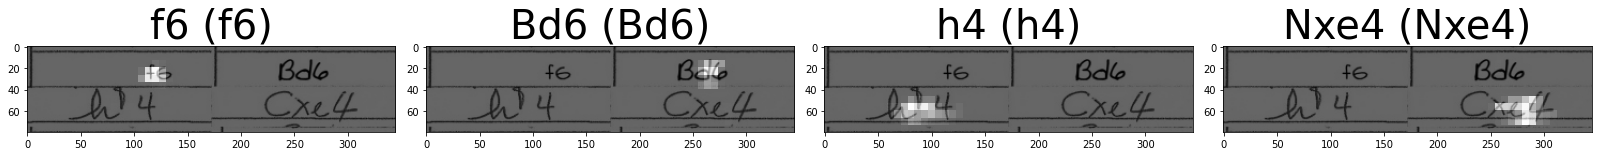

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['Nf3', 'c5', 'Nf3', 'e6']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


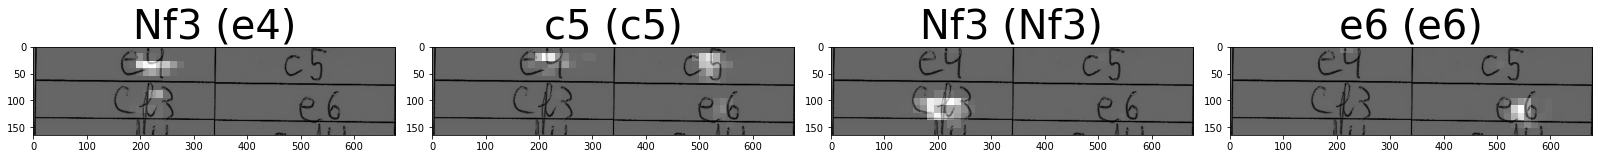

------------------------ 1 ------------------------------
predicted ['c4', 'c5', 'Nf3', 'd6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


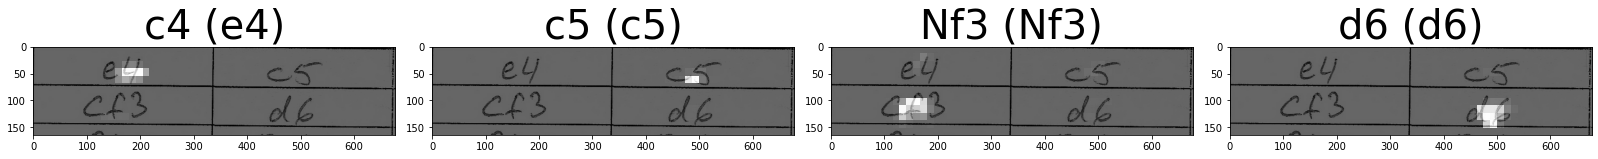

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'a3', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


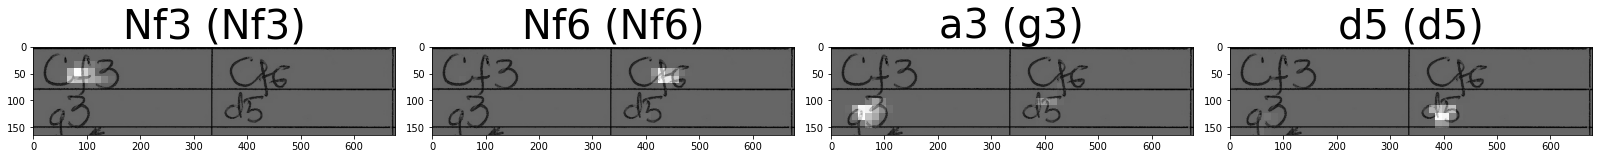

------------------------ 3 ------------------------------
predicted ['Nf3', 'g3', 'Nc3', 'Ne2']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


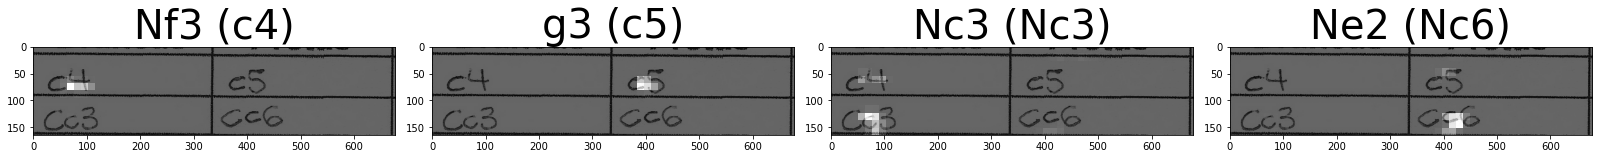

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4', 'Nf6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


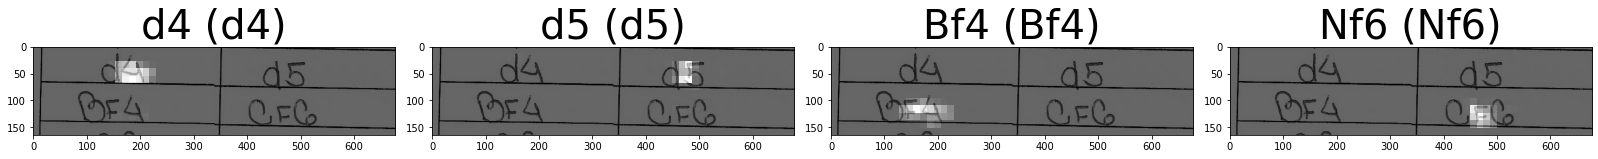

evaluating  100 ...
len 1 accuracy 0.6140350699424744 cir 0.23538013
len 2 accuracy 0.6710526347160339 cir 0.20614037
len 3 accuracy 0.7046783566474915 cir 0.18396688
len 4 accuracy 0.6688596606254578 cir 0.20504388


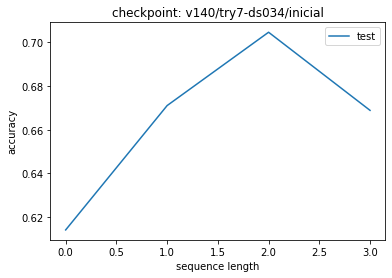

iniciando para lengh 4  target 0.1
len= 4  try_count= 0
-- loss_target=> 0.1  train_length= 4
Epoch 24 Batch 0 Loss 0.0187
Epoch 24 Batch 50 Loss 0.0618
Epoch 24 Batch 100 Loss 0.0271
Epoch 24 Batch 150 Loss 0.0316
Epoch 24 Batch 200 Loss 0.0641
Epoch 24 Batch 250 Loss 0.0542
Epoch 24 Batch 300 Loss 0.1186
Epoch 24 Batch 350 Loss 0.0929
Epoch 24 Batch 400 Loss 0.1124
Epoch 24 Batch 450 Loss 0.0782
Epoch 24 Batch 500 Loss 0.0398
Epoch 24 Batch 550 Loss 0.0905
Epoch 24 Batch 600 Loss 0.0650
Epoch 24 Loss 0.074132  acc: 0.9758 [ Validation Loss 0.536528 valid_acc: 0.8831 ]
Time taken for 1 epoch 1148.4104092121124 sec

08:10:13.13
Target reached! stop!  len=  4
saved checkpoint! /content/drive/My Drive/mestrado/v140/try7-ds034/inicial/checkpoints/train/ckpt-8


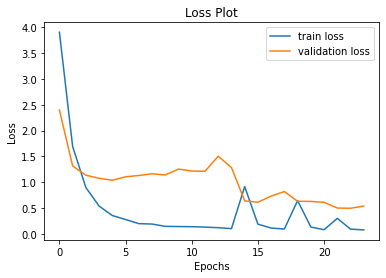

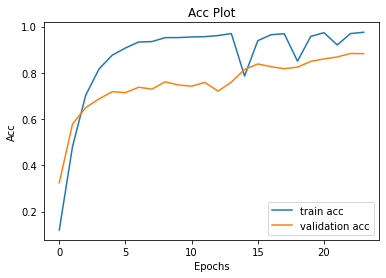

08:10:13.78
expected= ['e3', 'h6', 'Rb8', 'Bg7', '<end>']
predicted= ['e3', 'h6', 'Rb8', 'Bg7']
/content/dataset-v034--2lines-parts--42k/train/images/new-random_22bd2488.jpg


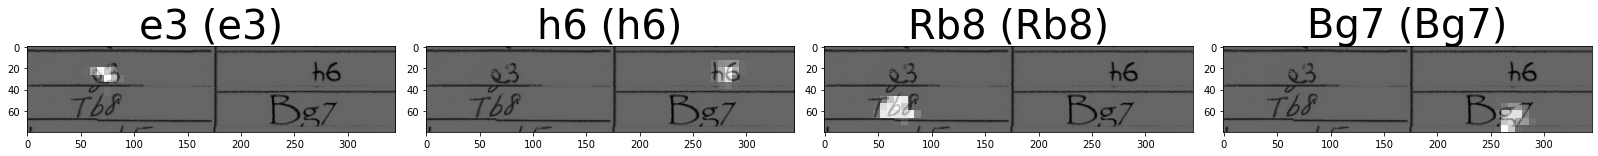

expected= ['f6', 'Bd6', 'h4', 'Nxe4', '<end>']
predicted= ['f6', 'Bd6', 'h4', 'Nxe4']
/content/dataset-v034--2lines-parts--42k/valid/images/new-random_24cf43f2.jpg


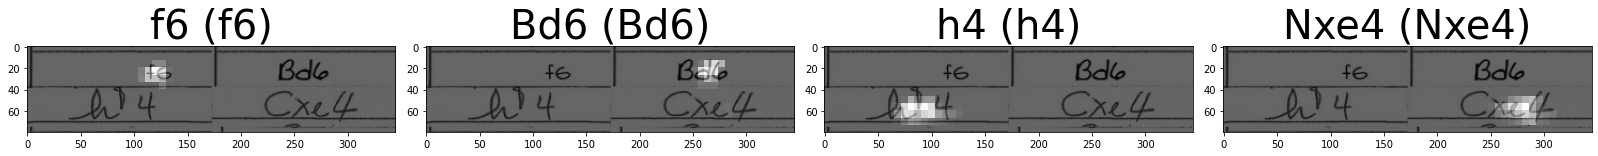

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['c4', 'c5', 'Nf3', 'e6']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


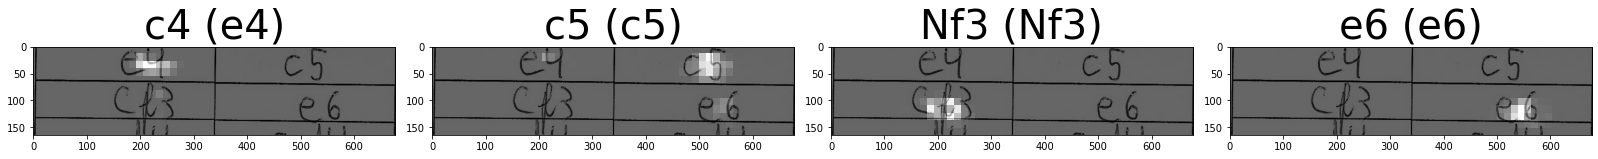

------------------------ 1 ------------------------------
predicted ['d4', 'd6', 'Nf3', 'd6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


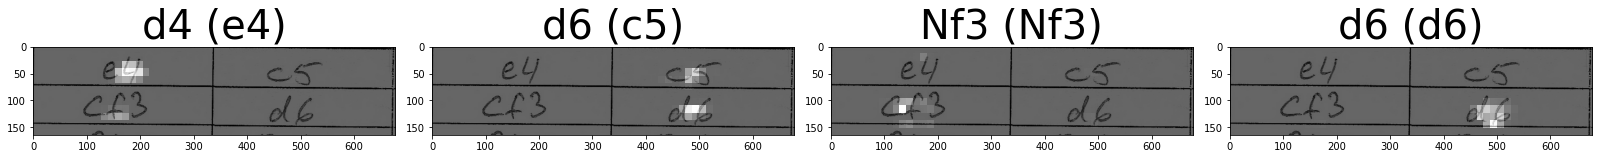

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'a3', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


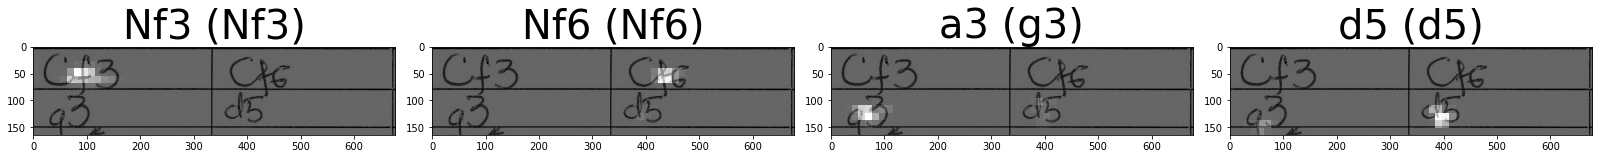

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3', 'Nc3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


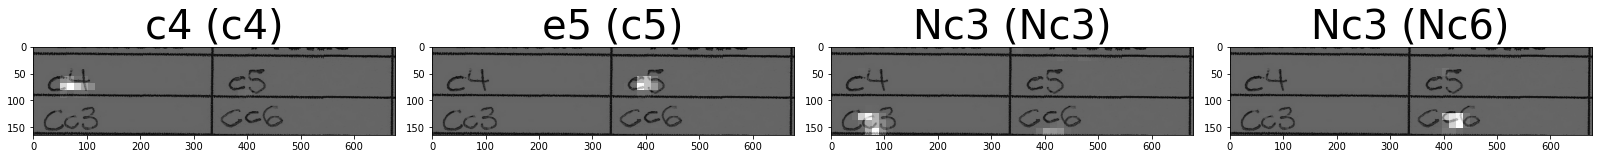

------------------------ 4 ------------------------------
predicted ['d4', 'd6', 'Bf4', 'Nf6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


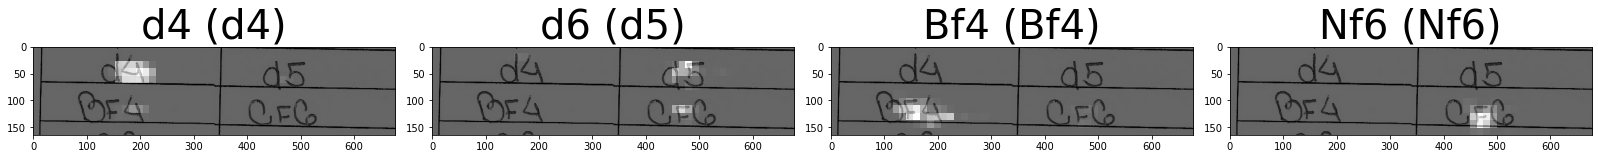

In [ ]:
for _len in [1,2,3,4]:
  for _target in [0.25,0.1]:
    print( 'iniciando para lengh', _len, ' target', _target)
    if not train_more_with_retry( _target, _len, 2000):
      print( 'numero de tentativas excedido sem sucesso. Abort')
      assert False

    print_time()    
    try:
      evaluate_train(1, _len)
      evaluate_valid(1, _len)
      make_evaluations_test_set(_len)
    except Exception as e:
      print( 'oops error..', e)